In [1]:
import vae_mnist as vae_mnist
from torchvision import transforms, datasets
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()

# download data for training
mnist_data = datasets.MNIST(root='./todata', train=True,
                            download=True, transform = transform)

# set dataloader
data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = 'cuda'

latent_dim = 6

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

mnist_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

conv_vae = vae_mnist.ConvVAE(latent_dim).to(device)
conv_vae.load_state_dict(torch.load('/content/drive/MyDrive/ML project data/conv_vae_mnist.pth', map_location=device))

<All keys matched successfully>

In [5]:
print(conv_vae.encoder.modules)
print(conv_vae.decoder.modules)

<bound method Module.modules of Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=12, bias=True)
)>
<bound method Module.modules of Sequential(
  (0): Linear(in_features=6, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=6272, bias=True)
  (3): ReLU()
  (4): Unflatten(dim=1, unflattened_size=(128, 7, 7))
  (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (8): ReLU()
  (9): ConvTranspose2d(32, 1, 

In [6]:
activations_encoder = {
    'layer1' : None,
    'layer2' : None,
    'layer3' : None,
    'layer4' : None,
}

activations_decoder = {
    'layer1' : None,
    'layer2' : None,
    'layer3' : None,
    'layer4' : None,
}
# activations_encoder = {}
def get_activation_foo(name, activations):
    def hookFoo(model, input, output):
        # if activations[name] == None:
        activations[name] = output.detach()
        # else:
        #     activations[name] = torch.cat((activations[name], output.detach()), 0)
    return hookFoo

def get_activation_foo_input(name, activations):
    def hookFoo(model, input, output):
        # if activations[name] == None:
        activations[name] = input[0].detach()
        # else:
        #     activations[name] = torch.cat((activations[name], input[0].detach()), 0)
    return hookFoo

conv_vae.encoder[0].register_forward_hook(get_activation_foo('layer1', activations_encoder))
conv_vae.encoder[2].register_forward_hook(get_activation_foo('layer2', activations_encoder))
conv_vae.encoder[4].register_forward_hook(get_activation_foo('layer3', activations_encoder))
conv_vae.encoder[9].register_forward_hook(get_activation_foo('layer4', activations_encoder))

conv_vae.decoder[0].register_forward_hook(get_activation_foo_input('layer1', activations_decoder))
conv_vae.decoder[5].register_forward_hook(get_activation_foo_input('layer2', activations_decoder))
conv_vae.decoder[7].register_forward_hook(get_activation_foo_input('layer3', activations_decoder))
conv_vae.decoder[9].register_forward_hook(get_activation_foo_input('layer4', activations_decoder))

# Small net

In [7]:
from smallnet import LinearNet, Net, split_dataset
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

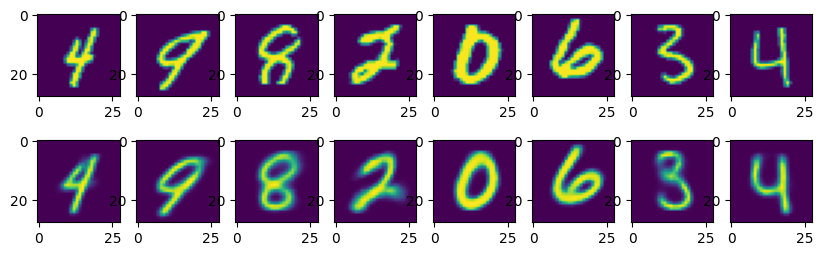

In [8]:
conv_vae.eval()

# Assuming 'test_data' is your MNIST test dataset
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

conv_vae.to(device)

data = torch.Tensor(next(iter(test_loader))[0]).to(device)


# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _ = conv_vae(data)

recov = []
origin = []
for i in range(8):
  origin.append(data[i].reshape(28,28))
  recov.append(reconstructed_images[i].reshape(28,28))

fig, ax = plt.subplots(nrows=2, ncols =8, figsize=(10,3))

for i in range(8):
  ax[0,i].imshow(origin[i].cpu().squeeze())
  ax[1,i].imshow(recov[i].cpu())

In [9]:
def transform_to_features(activations, batch_size):
    with torch.no_grad():
        feats = torch.Tensor([]).to(device)
        for key in activations.keys():
            val = activations[key]
            cur_feat = val[-batch_size:]
            if len(val.shape) == 4:
                cur_feat = val[-batch_size:].mean(dim=[2,3])
            feats = torch.cat((feats, cur_feat), dim=1)
            activations[key] = None
        torch.cuda.empty_cache()
    return feats

In [71]:
def train_model(train_loader, model, criterion, optimizer, model_vae, activations, epochs=90, loss_list=[], device='mps'):
    if activations == 'encoder':
      activations = activations_encoder
    elif activations == 'decoder':
      activations = activations_decoder

    model.train()
    loss_list = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                model_vae(images)
            # print(activations_decoder['layer1'].shape)
            if activations != 'mix':
              features_enc = transform_to_features(activations, labels.shape[0])
            else:
              features_enc = transform_to_features(activations_encoder, labels.shape[0])
              features_dec = transform_to_features(activations_decoder, labels.shape[0])
              features_enc = torch.cat((features_enc, features_dec), dim=1)


            features_enc = features_enc.to(device)
            outputs = model(features_enc)
            optimizer.zero_grad()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        # print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    return loss_list


def test_model(model, test_loader, model_vae, activations, device='mps'):
    if activations == 'encoder':
      activations = activations_encoder
    elif activations == 'decoder':
      activations = activations_decoder

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                model_vae(images)
            if activations != 'mix':
              features_enc = transform_to_features(activations, labels.shape[0])
            else:
              features_enc = transform_to_features(activations_encoder, labels.shape[0])
              features_dec = transform_to_features(activations_decoder, labels.shape[0])
              features_enc = torch.cat((features_enc, features_dec), dim=1)

            features_enc.to(device)

            outputs = model(features_enc)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

In [45]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch
import numpy as np
from smallnet import LinearNet, Net, split_dataset

In [ ]:
transform_to_features(activations_encoder, 8).shape

In [46]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./todata', train=True,
                            download=True, transform = transform)

train_indices, test_indices = split_dataset(mnist_data, num_train_per_class=32, num_test_per_class=32)

train_subset = Subset(mnist_data, train_indices)
test_subset = Subset(mnist_data, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32)


In [47]:
input_size = 236
num_classes = 10

model = LinearNet(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

conv_vae.to(device)

train_model(train_loader, model, criterion, optimizer, conv_vae, activations='encoder', epochs=90, loss_list=[], device=device);

100%|██████████| 90/90 [00:06<00:00, 13.44it/s]


In [48]:
# model.to('cpu')
# conv_vae.to('cpu')
test_model(model, test_loader, conv_vae, activations='encoder', device='cuda')


Accuracy: 79.6875%


79.6875

In [86]:
enc_accuracy_diff_size = []
for train_size in [2, 4, 8, 16, 32, 64, 128, 256, 512]:
    train_indices, test_indices = split_dataset(mnist_data, num_train_per_class=train_size, num_test_per_class=64)

    train_subset = Subset(mnist_data, train_indices)
    test_subset = Subset(mnist_data, test_indices)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32)

    input_size = 230
    num_classes = 10

    model = Net(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    conv_vae.to(device)

    train_model(train_loader, model, criterion, optimizer, conv_vae, activations='decoder', epochs=200, loss_list=[], device=device);
    # torch.save(model.state_dict(), f'smallnet-Net-{train_size}.pth')


    enc_accuracy_diff_size.append(test_model(model, test_loader, conv_vae, activations='decoder', device=device))

100%|██████████| 200/200 [00:01<00:00, 145.55it/s]


Accuracy: 80.3125%


100%|██████████| 200/200 [00:02<00:00, 71.78it/s]


Accuracy: 82.96875%


100%|██████████| 200/200 [00:04<00:00, 45.77it/s]


Accuracy: 86.40625%


100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


Accuracy: 86.875%


100%|██████████| 200/200 [00:15<00:00, 12.76it/s]


Accuracy: 89.53125%


100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Accuracy: 89.0625%


100%|██████████| 200/200 [01:02<00:00,  3.21it/s]


Accuracy: 95.78125%


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


Accuracy: 94.6875%


100%|██████████| 200/200 [04:04<00:00,  1.22s/it]

Accuracy: 94.53125%


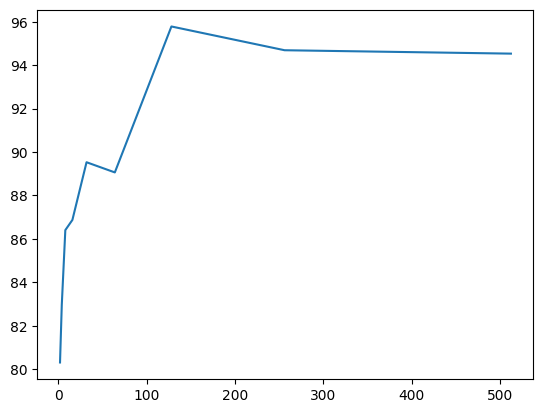

In [87]:
plt.plot([2, 4, 8, 16, 32, 64, 128, 256, 512], enc_accuracy_diff_size)

In [88]:
print(enc_accuracy_diff_size)

[80.3125, 82.96875, 86.40625, 86.875, 89.53125, 89.0625, 95.78125, 94.6875, 94.53125]
